In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from maraboupy import Marabou
from datetime import datetime

Instructions for updating:
non-resource variables are not supported in the long term


C:\Users\Leon\Downloads\Marabou-master\Marabou-master\maraboupy\Marabou.py:31: UserWarning: ONNX parser is unavailable because onnx or onnxruntime packages are not installed
  warnings.warn("ONNX parser is unavailable because onnx or onnxruntime packages are not installed")


## Parameters

### Parameters for the Tensorflow Model

In [2]:
TF_TRAIN_SHUFFLE = 10_000
TF_TRAIN_BATCH = 32
TF_TRAIN_EPOCHS = 5

### Parameters for Fast Gradient Sign Method

In [3]:
FGSM_EPSILON = 0.15
FGSM_NUM_SAMPLES = 1_000
FGSM_RETRAIN_SHUFFLE = 10_000
FGSM_RETRAIN_BATCH = 32
FGSM_RETRAIN_EPOCHS = 5

### Parameters for Marabou Adversarial Robustness

In [90]:
MB_MODEL_PATH = "mnist_model"
MB_NUM_SAMPLES = 1
MB_DELTA = 0.05
MB_EPSILON = 0.2

## Create and Train MNIST Model

### Obtain Dataset

In [5]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()
train_x = train_x.reshape((train_x.shape[0], 784)) / 255.0
test_x = test_x.reshape((test_x.shape[0], 784)) / 255.0
print("train data shape", train_x.shape, train_y.shape)
print("test data shape", test_x.shape, test_y.shape)

train data shape (60000, 784) (60000,)
test data shape (10000, 784) (10000,)


In [6]:
train_data = tf.data.Dataset \
    .from_tensor_slices((train_x, train_y)) \
    .shuffle(TF_TRAIN_SHUFFLE) \
    .batch(TF_TRAIN_BATCH)

### Create Model

In [7]:
tf_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(784)),
    tf.keras.layers.Dense(16, activation=tf.keras.layers.ReLU()),
    tf.keras.layers.Dense(16, activation=tf.keras.layers.ReLU()),
    tf.keras.layers.Dense(10),
])

In [8]:
tf_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                12560     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                170       
Total params: 13,002
Trainable params: 13,002
Non-trainable params: 0
_________________________________________________________________


### Train Model

In [9]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric_fn = tf.keras.metrics.SparseCategoricalAccuracy()
tf_model.compile(loss=loss_fn, metrics=[metric_fn])

In [10]:
tf_model.fit(train_data, epochs=TF_TRAIN_EPOCHS)

Epoch 1/5
1875/1875 [==============================] - 1s 556us/step - loss: 0.7727 - sparse_categorical_accuracy: 0.7684
Epoch 2/5
1875/1875 [==============================] - 1s 558us/step - loss: 0.2623 - sparse_categorical_accuracy: 0.9251
Epoch 3/5
1875/1875 [==============================] - 1s 569us/step - loss: 0.2267 - sparse_categorical_accuracy: 0.9353
Epoch 4/5
1875/1875 [==============================] - 1s 581us/step - loss: 0.2096 - sparse_categorical_accuracy: 0.9409
Epoch 5/5
1875/1875 [==============================] - 1s 553us/step - loss: 0.1954 - sparse_categorical_accuracy: 0.9449


### Evaluate on Test Data

In [11]:
tf_model.evaluate(test_x, test_y)

313/313 [==============================] - 0s 322us/step - loss: 0.1953 - sparse_categorical_accuracy: 0.9425


[0.19532063603401184, 0.9424999952316284]

## Try to Prove Adversarial Robustness Using Marabou

### Export for Marabou

In [12]:
tf.saved_model.save(tf_model, MB_MODEL_PATH)

INFO:tensorflow:Assets written to: mnist_model\assets


INFO:tensorflow:Assets written to: mnist_model\assets


### Generate Samples

In [91]:
mb_x = np.empty((0, 784), int)
mb_y = np.empty((0), int)

In [93]:
print("start time", datetime.now().strftime("%H:%M:%S"))

samples_to_try = zip(
    train_x[5:5+MB_NUM_SAMPLES],
    train_y[5:5+MB_NUM_SAMPLES]
)
for sample_index, (image, actual_label) in enumerate(samples_to_try):
    
    for target_label in range(10):
        if target_label == actual_label: continue
        
        mb_model = Marabou.read_tf(MB_MODEL_PATH, modelType="savedModel_v2")
        mb_input_vars = mb_model.inputVars[0][0]
        mb_output_vars = mb_model.outputVars[0]
        
        for variable, value in enumerate(image):
            mb_model.setLowerBound(mb_input_vars[variable], value - MB_DELTA)
            mb_model.setUpperBound(mb_input_vars[variable], value + MB_DELTA)
        
        #for label in range(10):
            #if label != target_label:
                #mb_model.addInequality(
                    #[ mb_output_vars[label], mb_output_vars[target_label] ],
                    #[ +1.0, -1.0 ], -1.0 * MB_EPSILON,
                    #[ mb_output_vars[target_label], mb_output_vars[label] ],
                    #[ +1.0, -1.0 ], MB_EPSILON,
                #)
        mb_model.addInequality(
            [ mb_output_vars[actual_label], mb_output_vars[target_label] ],
            [ +1.0, -1.0 ], -1.0 * MB_EPSILON
        )
        
        mb_variables, stats = mb_model.solve("marabou.log", verbose=False)
        if not mb_variables:
            print(f"unsat for sample {sample_index} with target label {target_label}")
            continue
        print(f"sat for sample {sample_index} with target label {target_label}")
        
        disturbed_image = list()
        for i in range(0, 784):
            disturbed_image.append(mb_variables[mb_input_vars[i]])
        
        mb_x = np.append(mb_x, np.array([disturbed_image]), axis=0)
        mb_y = np.append(mb_y, np.array([actual_label]), axis=0)

print("mb data shape", mb_x.shape, mb_y.shape)
np.save("mb_x.npy", mb_x)
np.save("mb_y.npy", mb_y)

print("end time", datetime.now().strftime("%H:%M:%S"))

start time 22:14:53
sat for sample 0 with target label 0
unsat for sample 0 with target label 1
sat for sample 0 with target label 3
sat for sample 0 with target label 4
sat for sample 0 with target label 5
unsat for sample 0 with target label 6
sat for sample 0 with target label 7
sat for sample 0 with target label 8
sat for sample 0 with target label 9
mb data shape (7, 784) (7,)
end time 22:35:57


In [94]:
tf_model.evaluate(mb_x, mb_y)

1/1 [==============================] - 0s 10ms/step - loss: 3.5563 - sparse_categorical_accuracy: 0.0000e+00


[3.556345224380493, 0.0]

tf.Tensor(9, shape=(), dtype=int64)
tf.Tensor(
[[1.62486176e-04 3.83304496e-07 9.97453835e-03 1.21829435e-02
  3.37352358e-05 5.72779449e-04 1.86876207e-06 1.50125695e-03
  2.21102629e-02 9.53459680e-01]], shape=(1, 10), dtype=float32)


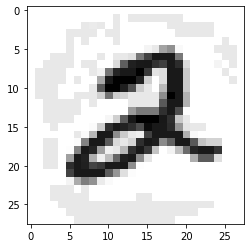

In [103]:
i = 1
print(tf.argmax(tf_model(tf.convert_to_tensor([mb_x[i]]))[0]))
print(tf.math.softmax(tf_model(tf.convert_to_tensor([mb_x[i]]))))
plt.imshow(mb_x[i].reshape((28, 28)), cmap=plt.cm.binary)
plt.imsave(f"adversarial_{i}.png", mb_x[i].reshape((28, 28)), cmap=plt.cm.binary)

### Plot the Found Samples

IndexError: index 1 is out of bounds for axis 0 with size 1

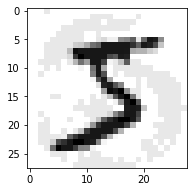

In [15]:
plt.figure(figsize=(10, 10))

for fig_index in range(9):
    image_index = fig_index
    image = mb_x[image_index].reshape((28, 28))
    
    plt.subplot(3, 3, fig_index + 1)
    plt.imshow(image, cmap=plt.cm.binary)

plt.show()

## Find Adversarial Samples Using FGSM

In [16]:
def fgsm(image, label):
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = tf_model(image)
        loss = loss_fn(label, prediction)
    gradient = tape.gradient(loss, image)
    return tf.sign(gradient) * 0.5 + 0.5

### Generate Samples

In [17]:
fgsm_x = np.empty((0, 784), int)
fgsm_y = np.empty((0), int)

In [18]:
print("start time", datetime.now().strftime("%H:%M:%S"))

samples_to_try = zip(
    train_x[:FGSM_NUM_SAMPLES],
    train_y[:FGSM_NUM_SAMPLES]
)
for sample_index, (image, actual_label) in enumerate(samples_to_try):
    
    for target_label in range(10):
        if target_label == actual_label: continue
            
        perturbations = fgsm(
            tf.convert_to_tensor([image]),
            tf.convert_to_tensor([actual_label])
        )[0]
        disturbed_image = tf.clip_by_value(
            image + perturbations * FGSM_EPSILON, 0, 255.0)
    
        fgsm_x = np.append(fgsm_x, np.array([disturbed_image]), axis=0)
        fgsm_y = np.append(fgsm_y, np.array([actual_label]), axis=0)

print("fgsm data shape", fgsm_x.shape, fgsm_y.shape)
np.save("fgsm_x.npy", fgsm_x)
np.save("fgsm_y.npy", fgsm_y)

print("end time", datetime.now().strftime("%H:%M:%S"))

start time 19:00:39
fgsm data shape (9000, 784) (9000,)
end time 19:01:59


### Plot Some of the Found Samples

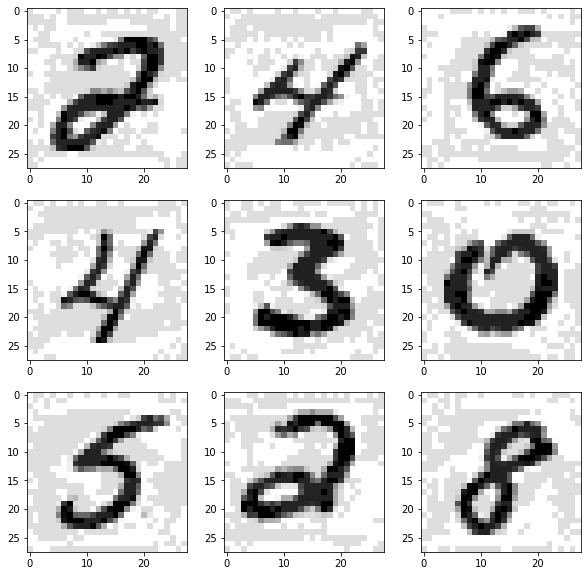

In [19]:
plt.figure(figsize=(10, 10))

for fig_index in range(9):
    image_index = np.random.choice(fgsm_x.shape[0], 1, replace=False)
    image = fgsm_x[image_index].reshape((28, 28))
    
    plt.subplot(3, 3, fig_index + 1)
    plt.imshow(image, cmap=plt.cm.binary)

plt.show()

### Evaluate on Found FGSM Samples

In [20]:
tf_model.evaluate(fgsm_x, fgsm_y)

282/282 [==============================] - 0s 575us/step - loss: 12.4506 - sparse_categorical_accuracy: 0.0380


[12.450562477111816, 0.03799999877810478]

## Adversarial Retraining Using FGSM Samples

In [21]:
retrain_x = np.append(train_x, fgsm_x, axis=0)
retrain_y = np.append(train_y, fgsm_y, axis=0)
retrain_data = tf.data.Dataset \
    .from_tensor_slices((retrain_x, retrain_y)) \
    .shuffle(FGSM_RETRAIN_SHUFFLE) \
    .batch(FGSM_RETRAIN_BATCH)

In [22]:
tf_model.fit(retrain_data, epochs=FGSM_RETRAIN_EPOCHS)

Epoch 1/5
2157/2157 [==============================] - 2s 825us/step - loss: 0.3723 - sparse_categorical_accuracy: 0.9040
Epoch 2/5
2157/2157 [==============================] - 2s 810us/step - loss: 0.1860 - sparse_categorical_accuracy: 0.9457
Epoch 3/5
2157/2157 [==============================] - 2s 821us/step - loss: 0.1532 - sparse_categorical_accuracy: 0.9560
Epoch 4/5
2157/2157 [==============================] - 2s 853us/step - loss: 0.1415 - sparse_categorical_accuracy: 0.9595
Epoch 5/5
2157/2157 [==============================] - 2s 824us/step - loss: 0.1321 - sparse_categorical_accuracy: 0.9612


### Evaluate on Test Data

In [23]:
tf_model.evaluate(test_x, test_y)

313/313 [==============================] - 0s 330us/step - loss: 0.1733 - sparse_categorical_accuracy: 0.9547


[0.1732788383960724, 0.9546999931335449]

### Evaluate on FGSM Samples

In [24]:
tf_model.evaluate(fgsm_x, fgsm_y)

282/282 [==============================] - 0s 541us/step - loss: 0.0021 - sparse_categorical_accuracy: 1.0000


[0.0020798910409212112, 1.0]

## Try to Prove Adversarial Robustness Using Marabou Again

### Export for Marabou

In [25]:
tf.saved_model.save(tf_model, MB_MODEL_PATH)

INFO:tensorflow:Assets written to: mnist_model\assets


INFO:tensorflow:Assets written to: mnist_model\assets


### Generate Samples

In [26]:
mb_x = np.empty((0, 784), int)
mb_y = np.empty((0), int)

In [27]:
print("start time", datetime.now().strftime("%H:%M:%S"))

samples_to_try = zip(
    train_x[:MB_NUM_SAMPLES],
    train_y[:MB_NUM_SAMPLES]
)
for sample_index, (image, actual_label) in enumerate(samples_to_try):
    
    for target_label in range(10):
        if target_label == actual_label: continue
        
        mb_model = Marabou.read_tf(MB_MODEL_PATH, modelType="savedModel_v2")
        mb_input_vars = mb_model.inputVars[0][0]
        mb_output_vars = mb_model.outputVars[0]
        
        for variable, value in enumerate(image):
            mb_model.setLowerBound(mb_input_vars[variable], value - MB_DELTA)
            mb_model.setUpperBound(mb_input_vars[variable], value + MB_DELTA)
        
        for label in range(10):
            if label != target_label:
                mb_model.addInequality(
                    [ mb_output_vars[label], mb_output_vars[target_label] ],
                    [ +1.0, -1.0 ], -1.0 * MB_EPSILON,
                )
        
        mb_variables, stats = mb_model.solve("marabou.log", verbose=False)
        if not mb_variables:
            print(f"unsat for sample {sample_index} with target label {target_label}")
            continue
        print(f"sat for sample {sample_index} with target label {target_label}")
        
        disturbed_image = list()
        for i in range(0, 784):
            disturbed_image.append(mb_variables[mb_input_vars[i]])
        
        mb_x = np.append(mb_x, np.array([disturbed_image]), axis=0)
        mb_y = np.append(mb_y, np.array([actual_label]), axis=0)

print("mb data shape", mb_x.shape, mb_y.shape)
np.save("mb_x.npy", mb_x)
np.save("mb_y.npy", mb_y)

print("end time", datetime.now().strftime("%H:%M:%S"))

start time 19:02:57
sat for sample 0 with target label 0
sat for sample 0 with target label 1
sat for sample 0 with target label 2
sat for sample 0 with target label 3
sat for sample 0 with target label 4
sat for sample 0 with target label 6
sat for sample 0 with target label 7
sat for sample 0 with target label 8
sat for sample 0 with target label 9
mb data shape (9, 784) (9,)
end time 19:03:22


### Plot the Found Samples

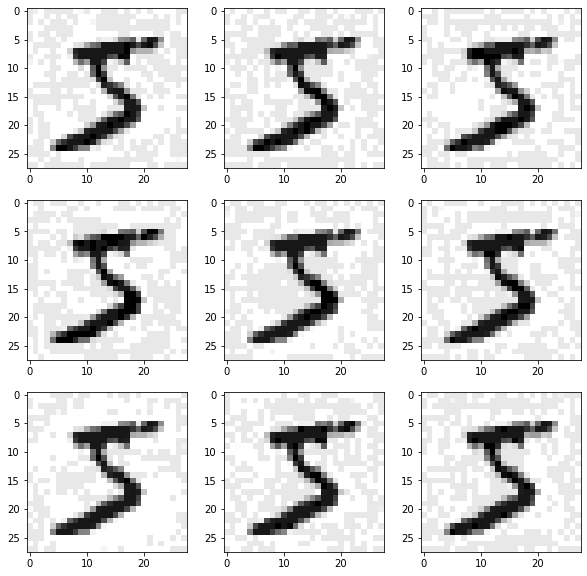

In [28]:
plt.figure(figsize=(10, 10))

for fig_index in range(9):
    image_index = fig_index
    image = mb_x[image_index].reshape((28, 28))
    
    plt.subplot(3, 3, fig_index + 1)
    plt.imshow(image, cmap=plt.cm.binary)

plt.show()

### Evaluate on Found Samples

In [29]:
tf_model.evaluate(mb_x, mb_y)

1/1 [==============================] - 0s 11ms/step - loss: 1.5397 - sparse_categorical_accuracy: 0.0000e+00


[1.5397276878356934, 0.0]